In [24]:
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Initial Exploratory Data Analysis

## Dataset exploration

In [30]:
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")

In [31]:
d_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_dynamicLimit.csv')
s_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_staticLimit.csv')

The two datasets differ in the way supply from the grid is limited. `s_data` contains static limit of 50kW, while `d_data` has a dynamic limit that changes over time. Perhaps to avoid higher loads on the grid at suboptimmaltimes of the day (when a lot of people use electricity)?

In [32]:
s_data["POWER_DEMAND"] = s_data["WALLBOX_1_POWER"] + s_data["WALLBOX_2_POWER"] + s_data["WALLBOX_3_POWER"] + s_data["WALLBOX_A_POWER"] + s_data["WALLBOX_B_POWER"] + s_data["WALLBOX_C_POWER"] + s_data["WALLBOX_FASTCHARGER_POWER"]
s_data["POWER_SUPPLY"] = s_data["GARAGE_EXTERNAL_POWER"] + s_data["PV_POWER"] + s_data["BATTERY_DISCHARGE_POWER"]

In [6]:
s_data.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,...,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,...,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066,15.242758,16.551039
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,...,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631,23.876519,24.569700
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,...,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000,0.147030,-23.178345
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,...,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472,0.197642,0.901735
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,...,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256,5.223808,5.885979
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,...,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050,15.560868,16.702183
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,...,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511,117.407838,129.619329


In [33]:
len(s_data[s_data["POWER_SUPPLY"] != s_data["POWER_DEMAND"]])

59442

Sanity check above shows some potential anomalies:



    - What does negative external power mean?
    - What does negative PV power mean?
    - Why do total supply and demand not match?
 

## Peak-shaving

In [34]:
def check_peak_shaving(row):
    if row['GARAGE_EXTERNAL_POWER'] >= row['DEMAND_LIMIT']:
        return True
    else:
        return False

s_data['Peak_Shaving'] = s_data.apply(check_peak_shaving, axis=1)

In [35]:
def adjust_peak_shaving(row):
    if row['Peak_Shaving'] == True:
        if row['BATTERY_DISCHARGE_POWER'] > 0 or row['PV_POWER'] > 0:
            return True
        else:
            return False
    else:
        return False


s_data['Peak_Shaving'] = s_data.apply(adjust_peak_shaving, axis=1)

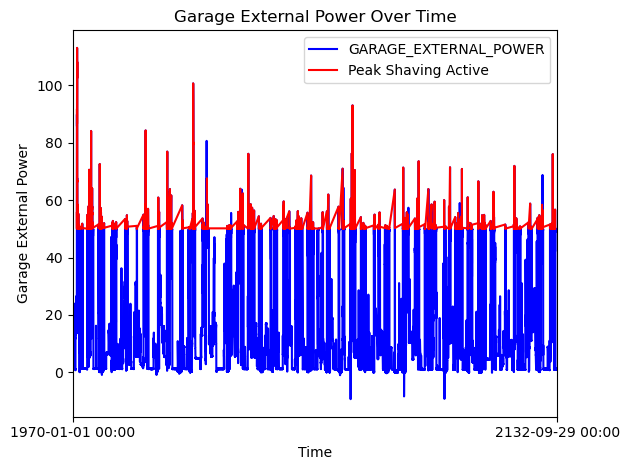

In [36]:
s_data.index = pd.to_datetime(s_data.index)
fig, ax = plt.subplots()
s_data['GARAGE_EXTERNAL_POWER'].plot(ax=ax, color='blue')  
s_data.loc[s_data['Peak_Shaving']==1, 'GARAGE_EXTERNAL_POWER'].plot(ax=ax, color='red',  label='Peak Shaving Active')  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xlabel('Time')
plt.ylabel('Garage External Power')
plt.title('Garage External Power Over Time')
plt.legend()
plt.tight_layout()
# plt.savefig('Figure/garg_ext_over_time.pdf')
plt.show()

## Ground Truth Analysis
Siemens provided/suggested the following ground truths:
- SOC > 80%: e-cars charging is completely covered by the local battery
- 40% < SOC < 80%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
- SOC < 40%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
    - If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
- SOC < 15%: Battery discharging is stopped due to battery health

First, we try to recover them from the dataset.

In [39]:
s_data = s_data[['_time','GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
      #  'DEMAND_LIMIT_INDICATOR', 
       'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY'
    ]]

In [40]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
s_data["DRAWN_FROM"] = s_data.apply(label_charging, axis=1)

In [41]:
features = s_data.drop(['_time','DRAWN_FROM', 'BATTERY_DISCHARGE_POWER', 'BATTERY_CHARGED_ENERGY',  'BATTERY_DISCHARGED_ENERGY', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = s_data['DRAWN_FROM']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [42]:

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'max_depth': [4, 6, 8, 10],
    'objective': ['binary:logistic']
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': [4, 6, 8, 10],
                         'objective': ['binary:logistic']},
             scoring='accuracy')

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9254773319875516
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10957
           1       1.00      1.00      1.00        40
           2       0.51      0.16      0.24       892

    accuracy                           0.93     11889
   macro avg       0.82      0.71      0.73     11889
weighted avg       0.90      0.93      0.91     11889

[[10823     0   134]
 [    0    40     0]
 [  752     0   140]]


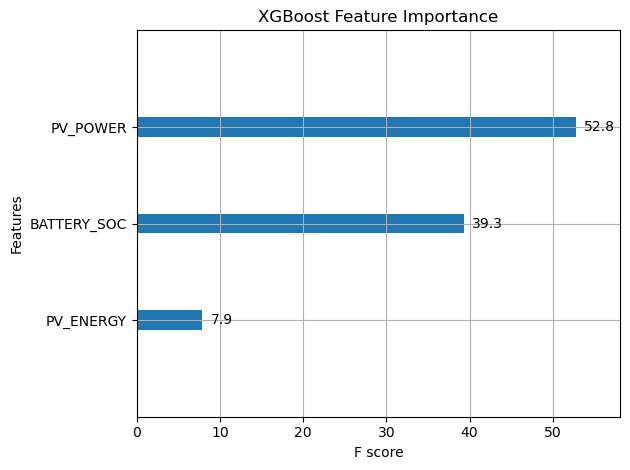

In [44]:
importance = best_model.get_booster().get_score(importance_type='weight')
total = sum(importance.values())
importance = {k: round((v / total) * 100, 1) for k, v in importance.items()}
xgb.plot_importance(importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgbfeature_importance.pdf')
plt.show()

Interestingly, solar power is very important. This is definitely worth further exploring. Let's examine the ground truth rules a bit closer now.

In [21]:
print("Number of instances where battery SOC > 80%:", len(s_data[s_data["BATTERY_SOC"]>80]))
print("Number of instances where battery is not charging when it should be:", len(s_data[(s_data["BATTERY_SOC"]<40) & (s_data["BATTERY_DISCHARGE_POWER"]>0) & (s_data["GARAGE_EXTERNAL_POWER"]<s_data["DEMAND_LIMIT"])]))
print("Number of instances where battery is still discharging, despite SOC<15%:", len(s_data[(s_data["BATTERY_SOC"]<15) & (s_data["BATTERY_DISCHARGE_POWER"]>0)]))

Number of instances where battery SOC > 80%: 0
Number of instances where battery is not charging when it should be: 2954
Number of instances where battery is still discharging, despite SOC<15%: 55


Apparently, the rules are often broken. We construct a cleaned dataset that contains only instances, that are in line with the provided rules.

In [45]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = s_data[(s_data["BATTERY_SOC"]<=15) & (s_data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<50) & (s_data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=s_data["GARAGE_EXTERNAL_POWER"]) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = s_data[(s_data["BATTERY_SOC"]>=40) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]

In [46]:
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(s_data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [47]:

DROPPED_COLUMNS = ['DRAWN_FROM', '_time', 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 'POWER_DEMAND', 'WALLBOX_FASTCHARGER_POWER', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]     #.drop(DROPPED_COLUMNS, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree.fit(X_train, y_train)
accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.7134020618556701


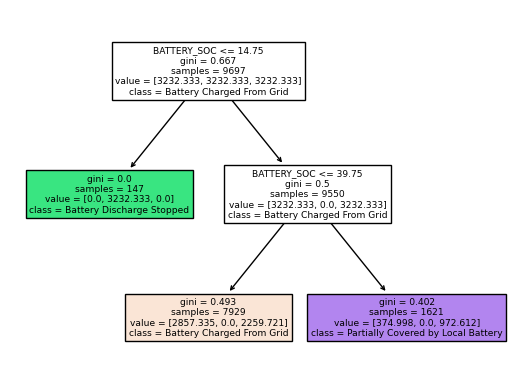

In [49]:
tree.fit(X, y)
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])
# plt.savefig('Figure/tree.pdf')